In [22]:
import sionna.rt


from sionna.rt import load_scene, PlanarArray,RadioMapSolver, Transmitter, Receiver, Camera, PathSolver, ITURadioMaterial, SceneObject # type: ignore

scene = load_scene('scenarios_private/scenario-flat/scenario.xml')
scene.frequency=1.0001e+09

scene.tx_array = PlanarArray(num_rows=1,
                               num_cols=1,
                               vertical_spacing=0.5,
                               horizontal_spacing=0.5,
                               pattern="dipole",
                               polarization="V")

# Configure receiver array properties
scene.rx_array = PlanarArray(num_rows=1,
                               num_cols=1,
                               vertical_spacing=0.5,
                               horizontal_spacing=0.5,
                               pattern="iso",
                               polarization="cross")
print(scene.frequency)
scene.add(Transmitter(name='Transmitter', position=[0,0,5],display_radius=2))
rm_solver = RadioMapSolver()
rm = rm_solver(scene=scene,
               max_depth=5,
               samples_per_tx=10**9,
               cell_size=(10,10),
               center=[0,0,1],
               size=[3000,3000],
               orientation=[0,0,0])
cam = Camera(position=[100,100,50],
             look_at=[0,0,20])



[1.0001e+09]


In [23]:
scene.preview(radio_map=rm);

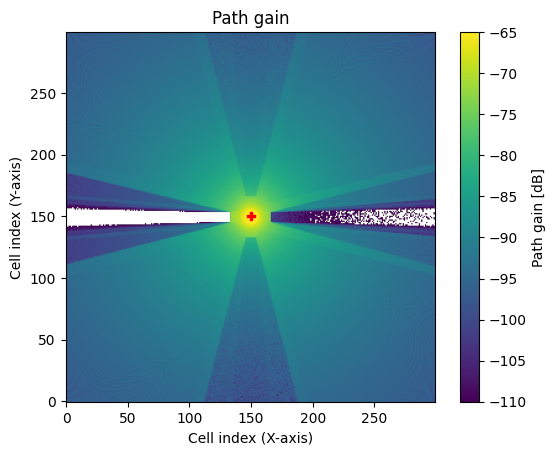

In [24]:
rm.show(metric="path_gain",vmax=-65,vmin=-110);